In [17]:
# Step 0: Setup & Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')


In [18]:
file_path = 'Sample - Superstore.xlsx'
xls = pd.ExcelFile(file_path)
orders_df = pd.read_excel(xls, sheet_name='Orders')
returns_df = pd.read_excel(xls, sheet_name='Returns')
people_df = pd.read_excel(xls, sheet_name='People')
orders_df['Returned'] = orders_df['Order ID'].isin(returns_df['Order ID']).astype(int)
final_df = pd.merge(orders_df, people_df, on='Region', how='left')


Mean Returns by Region:
Sales     574300.215075
Profit     71599.255425
dtype: float64

Covariance Matrix:
               Sales        Profit
Sales   2.414585e+10  4.838092e+09
Profit  4.838092e+09  1.129090e+09

✅ Optimal Portfolio (Markowitz - Max Sharpe):
Central: 0.9500
East: 0.0500

🔹 Return: 549165.1671
🔹 Volatility: 149177.9924
🔹 Sharpe Ratio: 3.6813


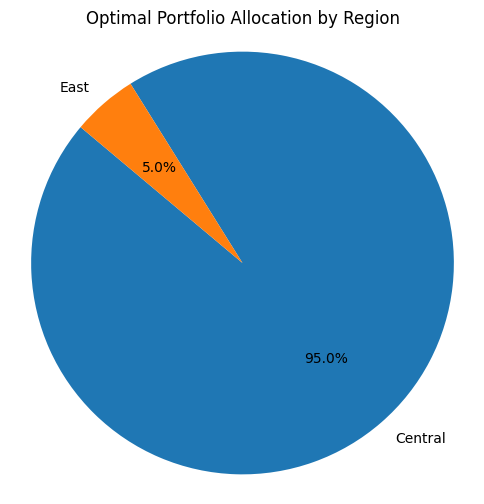

In [19]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Define the neg_sharpe function
def neg_sharpe(weights, mean_returns, cov_matrix, rf):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -((ret - rf) / vol)

# Calculate mean returns and covariance matrix by region
region_sales_returns = final_df.groupby('Region')[['Sales', 'Profit']].sum()
mean_returns = region_sales_returns.mean()
cov_matrix = region_sales_returns.cov()

# Print mean returns and covariance matrix to check data
print('Mean Returns by Region:')
print(mean_returns)
print('\nCovariance Matrix:')
print(cov_matrix)

# Set a minimum allocation (e.g., 0.05) for each region to encourage diversification
min_weight = 0.05
bounds = tuple((min_weight, 1) for _ in range(len(mean_returns)))

# Example initial guess and risk-free rate
dim = len(mean_returns)
initial_guess = [1/dim] * dim
rf = 0.02 / 12
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Optimization with diversification constraint
opt_result = minimize(neg_sharpe, initial_guess,
                      args=(mean_returns, cov_matrix, rf),
                      method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = opt_result.x
# Only use regions with nonzero weights for the pie chart
nonzero_idx = np.where(optimal_weights > 1e-6)[0]
pie_labels = [region_sales_returns.index[i] for i in nonzero_idx]
pie_weights = optimal_weights[nonzero_idx]

# Print results
print("\n✅ Optimal Portfolio (Markowitz - Max Sharpe):")
for region, weight in zip(region_sales_returns.index, optimal_weights):
    print(f"{region}: {weight:.4f}")

print(f"\n🔹 Return: {np.dot(optimal_weights, mean_returns):.4f}")
print(f"🔹 Volatility: {np.sqrt(optimal_weights.T @ cov_matrix @ optimal_weights):.4f}")
print(f"🔹 Sharpe Ratio: {(np.dot(optimal_weights, mean_returns) - rf) / np.sqrt(optimal_weights.T @ cov_matrix @ optimal_weights):.4f}")

plt.figure(figsize=(6,6))
plt.pie(pie_weights, labels=pie_labels, autopct='%1.1f%%', startangle=140)
plt.title("Optimal Portfolio Allocation by Region")
plt.axis('equal')
plt.show()


## Data Loading and Preparation

This step loads the Superstore dataset, merges the relevant sheets, and prepares the main DataFrame for analysis.

In [20]:
# === Libraries Used ===
import pandas as pd
import numpy as np

# === Load the Excel File ===
file_path = 'Sample - Superstore.xlsx'  # adjust path if needed
xls = pd.ExcelFile(file_path)

# === Load All Three Sheets ===
orders_df = pd.read_excel(xls, sheet_name='Orders')
returns_df = pd.read_excel(xls, sheet_name='Returns')
people_df = pd.read_excel(xls, sheet_name='People')

# === Merge Returns Info into Orders ===
# Add 'Returned' column based on matching Order IDs
orders_df['Returned'] = orders_df['Order ID'].isin(returns_df['Order ID']).astype(int)

# === Merge People Info into Orders (optional: to map each Region to Manager) ===
# people_df contains mapping: Region -> Person (Manager)
final_df = pd.merge(orders_df, people_df, on='Region', how='left')

# === Create High Profit Flag ===
# Use a threshold based on Profit distribution for better visual balance
# Example: Top 25% profit is considered high
profit_threshold = final_df['Profit'].quantile(0.75)
final_df['High_Profit'] = (final_df['Profit'] > profit_threshold).astype(int)

# === Convert Dates to datetime (for future time series work) ===
final_df['Order Date'] = pd.to_datetime(final_df['Order Date'])
final_df['Ship Date'] = pd.to_datetime(final_df['Ship Date'])

# === Final Columns Overview ===
print(final_df.shape)
print(final_df.columns)


(9994, 24)
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country/Region', 'City',
       'State', 'Postal Code', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Returned', 'Person', 'High_Profit'],
      dtype='object')


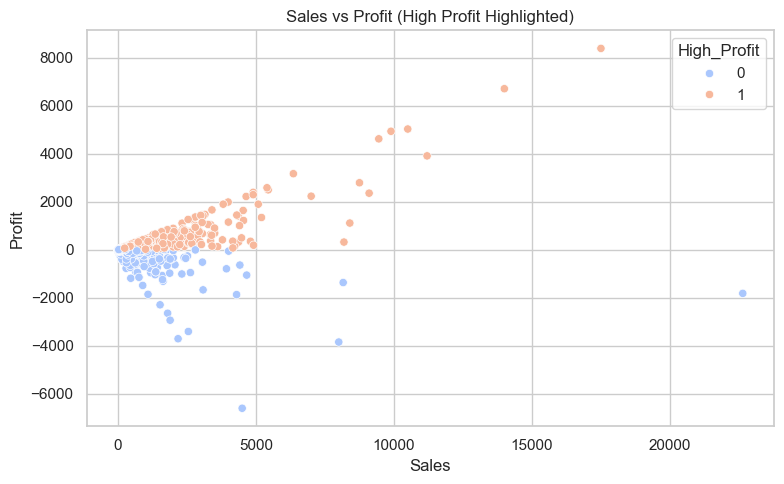

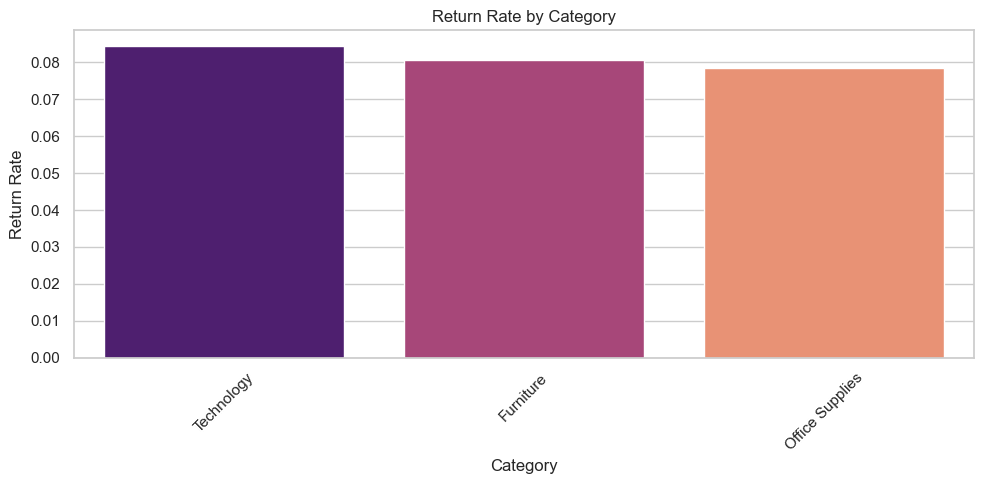

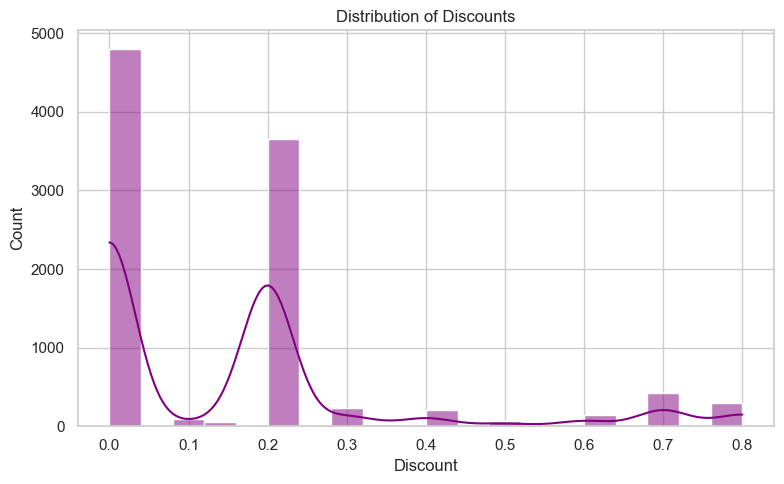

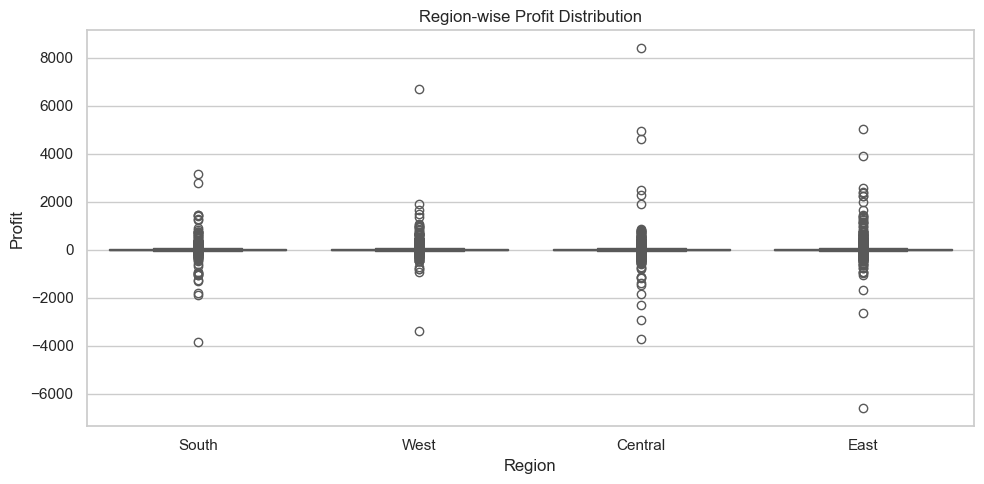

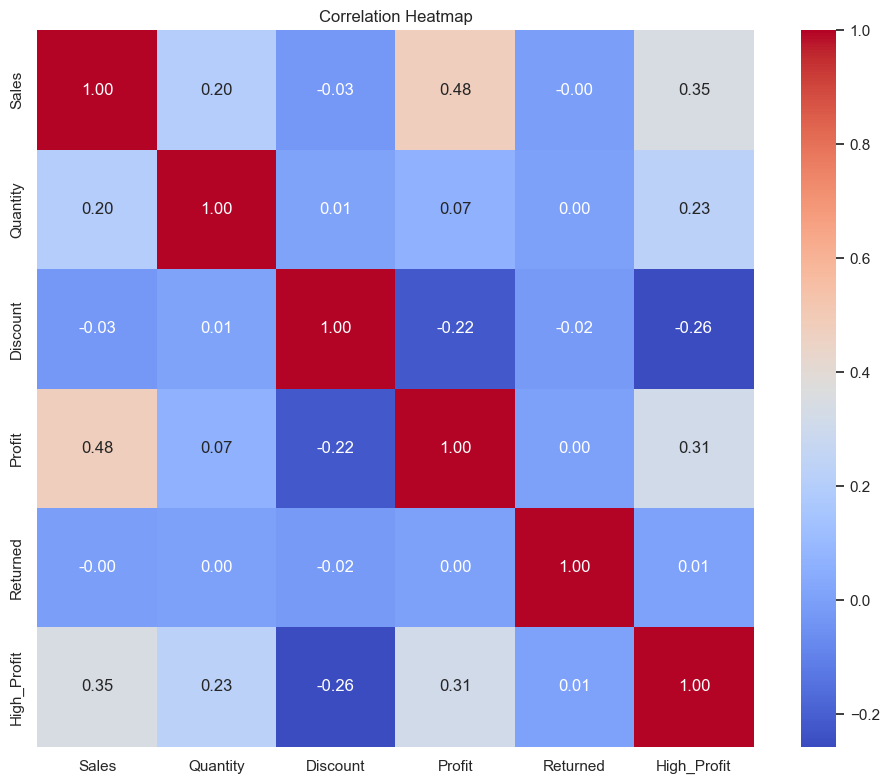

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set(style='whitegrid')

# 1.1 Sales vs Profit (Colored by High Profit)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=final_df, x='Sales', y='Profit', hue='High_Profit', palette='coolwarm')
plt.title('Sales vs Profit (High Profit Highlighted)')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.grid(True)
plt.tight_layout()
plt.show()

# 1.2 Return Rate by Category
plt.figure(figsize=(10, 5))
# Ensure 'Returned' is numeric
final_df['Returned'] = pd.to_numeric(final_df['Returned'], errors='coerce').fillna(0).astype(int)
return_rate = final_df.groupby('Category')['Returned'].mean().sort_values(ascending=False)
sns.barplot(x=return_rate.index, y=return_rate.values, palette='magma')
plt.title('Return Rate by Category')
plt.ylabel('Return Rate')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.3 Discount Distribution
plt.figure(figsize=(8, 5))
sns.histplot(final_df['Discount'], bins=20, kde=True, color='purple')
plt.title('Distribution of Discounts')
plt.xlabel('Discount')
plt.tight_layout()
plt.show()

# 1.4 Region-wise Profit Distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='Region', y='Profit', data=final_df, palette='Set2')
plt.title('Region-wise Profit Distribution')
plt.xlabel('Region')
plt.ylabel('Profit')
plt.tight_layout()
plt.show()

# 1.5 Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = final_df[['Sales', 'Quantity', 'Discount', 'Profit', 'Returned', 'High_Profit']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [22]:
import numpy as np

# 2.1 Order_Month and Order_Year
final_df['Order Date'] = pd.to_datetime(final_df['Order Date'])
final_df['Order_Month'] = final_df['Order Date'].dt.month
final_df['Order_Year'] = final_df['Order Date'].dt.year

# 2.2 Shipping Duration (in days)
final_df['Ship Date'] = pd.to_datetime(final_df['Ship Date'])
final_df['Shipping_Duration'] = (final_df['Ship Date'] - final_df['Order Date']).dt.days

# 2.3 Sales per Quantity
final_df['Sales_Per_Quantity'] = final_df['Sales'] / final_df['Quantity']
final_df['Sales_Per_Quantity'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 2.4 Discount Level
def classify_discount(x):
    if x == 0:
        return 'No Discount'
    elif x <= 0.1:
        return 'Low'
    elif x <= 0.3:
        return 'Medium'
    else:
        return 'High'

final_df['Discount_Level'] = final_df['Discount'].apply(classify_discount)

# 2.5 Shipping Speed Category
def shipping_speed(mode):
    if mode in ['Same Day']:
        return 'Fast'
    elif mode in ['First Class']:
        return 'Moderate'
    else:
        return 'Normal'

final_df['Shipping_Speed'] = final_df['Ship Mode'].apply(shipping_speed)

# 2.6 Profitability Category (optional if High_Profit exists)
# But for richer insight, create a 3-level version
def profit_category(p):
    if p <= 0:
        return 'Loss'
    elif p < 100:
        return 'Low Profit'
    else:
        return 'High Profit'

final_df['Profitability'] = final_df['Profit'].apply(profit_category)

# Feature Engineering - Date based
final_df['Order_Year'] = final_df['Order Date'].dt.year
final_df['Order_Month'] = final_df['Order Date'].dt.month
final_df['Order_DayOfWeek'] = final_df['Order Date'].dt.dayofweek  # Monday=0, Sunday=6

final_df['Ship_Year'] = final_df['Ship Date'].dt.year
final_df['Ship_Month'] = final_df['Ship Date'].dt.month
final_df['Ship_DayOfWeek'] = final_df['Ship Date'].dt.dayofweek

# Drop raw datetime columns (to avoid model errors)
final_df.drop(['Order Date', 'Ship Date'], axis=1, inplace=True)



In [23]:
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# 3.1: Is there a significant difference in average profit between returned and non-returned orders?
# H₀: There is no difference in average profit (μ₁ = μ₂)
# H₁: There is a significant difference (μ₁ ≠ μ₂)

returned_profit = final_df[final_df['Returned'] == 1]['Profit']
not_returned_profit = final_df[final_df['Returned'] == 0]['Profit']

t_stat, p_val = ttest_ind(returned_profit, not_returned_profit, equal_var=False, nan_policy='omit')
print(" Profit Difference Between Returned and Non-Returned Orders")
print(f"  H₀: μ_returned = μ_not_returned")
print(f"  H₁: μ_returned ≠ μ_not_returned")
print(f"  t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("  ❗Reject H₀: Significant difference in average profit.")
else:
    print("  ✅Fail to reject H₀: No significant difference.\n")

# 3.2: Does offering a discount increase the likelihood of returns?
# H₀: Discount level and return status are independent
# H₁: Discount level and return status are dependent

contingency_table = pd.crosstab(final_df['Discount_Level'], final_df['Returned'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(" Discount Level vs Return Status (Chi-Square Test)")
print("  H₀: Discount level and return status are independent")
print("  H₁: Discount level and return status are dependent")
print(f"  Chi2 Statistic = {chi2_stat:.4f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("  ❗Reject H₀: Discount level is associated with return status.")
else:
    print("  ✅Fail to reject H₀: No association between discount level and return.\n")

# 3.3: Is there a difference in average shipping duration across shipping modes?
# H₀: All shipping modes have the same mean shipping duration
# H₁: At least one shipping mode has a different mean

groups = [g['Shipping_Duration'].dropna() for name, g in final_df.groupby('Ship Mode')]
f_stat, p_val = f_oneway(*groups)
print(" Shipping Duration vs Ship Mode (ANOVA)")
print("  H₀: Mean shipping duration is same across all ship modes")
print("  H₁: At least one ship mode has a different mean duration")
print(f"  F-statistic = {f_stat:.4f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("  ❗Reject H₀: Shipping duration varies across shipping modes.")
else:
    print("  ✅Fail to reject H₀: No significant difference in shipping duration.\n")

# 3.4: Is there a difference in Sales per Quantity across discount levels?
# H₀: Mean Sales_Per_Quantity is same for all discount levels
# H₁: At least one discount level has a different mean Sales_Per_Quantity

groups = [g['Sales_Per_Quantity'].dropna() for name, g in final_df.groupby('Discount_Level')]
f_stat, p_val = f_oneway(*groups)
print(" Sales per Quantity vs Discount Level (ANOVA)")
print("  H₀: Mean Sales/Quantity is the same across all discount levels")
print("  H₁: At least one discount level has a different mean Sales/Quantity")
print(f"  F-statistic = {f_stat:.4f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("  ❗Reject H₀: Discount level affects Sales/Quantity.")
else:
    print("  ✅Fail to reject H₀: No significant difference in Sales/Quantity.\n")


 Profit Difference Between Returned and Non-Returned Orders
  H₀: μ_returned = μ_not_returned
  H₁: μ_returned ≠ μ_not_returned
  t-statistic = 0.0389, p-value = 0.9690
  ✅Fail to reject H₀: No significant difference.

 Discount Level vs Return Status (Chi-Square Test)
  H₀: Discount level and return status are independent
  H₁: Discount level and return status are dependent
  Chi2 Statistic = 3.5763, p-value = 0.3110
  ✅Fail to reject H₀: No association between discount level and return.

 Shipping Duration vs Ship Mode (ANOVA)
  H₀: Mean shipping duration is same across all ship modes
  H₁: At least one ship mode has a different mean duration
  F-statistic = 7058.3337, p-value = 0.0000
  ❗Reject H₀: Shipping duration varies across shipping modes.
 Sales per Quantity vs Discount Level (ANOVA)
  H₀: Mean Sales/Quantity is the same across all discount levels
  H₁: At least one discount level has a different mean Sales/Quantity
  F-statistic = 12.4313, p-value = 0.0000
  ❗Reject H₀: Disc

In [24]:

# 🎯 Common Preprocessing for ML
df_ml = final_df.copy()

# --- Label Encoding for categoricals
label_cols = ['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category', 'Discount_Level', 'Person']
le = LabelEncoder()
for col in label_cols:
    df_ml[col] = le.fit_transform(df_ml[col])

# 🎯 GOAL 1: Predict Return (Classification)

features_cls = ['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping_Duration', 'High_Profit'] + label_cols
X_cls = df_ml[features_cls]
y_cls = df_ml['Returned']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

# 🔄 Scaling
scaler = StandardScaler()
X_train_cls = scaler.fit_transform(X_train_cls)
X_test_cls = scaler.transform(X_test_cls)

#📦 Model 1: Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_cls, y_train_cls)
y_pred_lr = lr.predict(X_test_cls)
print("📊 Logistic Regression - Return Prediction")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_lr):.4f}")
print(confusion_matrix(y_test_cls, y_pred_lr))
print(classification_report(y_test_cls, y_pred_lr))

#  Model 2: Decision Tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train_cls, y_train_cls)
y_pred_tree = tree.predict(X_test_cls)
print("🌳 Decision Tree - Return Prediction")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_tree):.4f}")
print(confusion_matrix(y_test_cls, y_pred_tree))
print(classification_report(y_test_cls, y_pred_tree))

#  Model 3: Support Vector Machine (SVM)
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_cls, y_train_cls)
y_pred_svm = svm.predict(X_test_cls)
print("🧠 SVM - Return Prediction")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_svm):.4f}")
print(confusion_matrix(y_test_cls, y_pred_svm))
print(classification_report(y_test_cls, y_pred_svm))


#  GOAL 2: Predict Profit (Regression)

features_reg = ['Sales', 'Quantity', 'Discount', 'Shipping_Duration', 'High_Profit'] + label_cols
X_reg = df_ml[features_reg]
y_reg = df_ml['Profit']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

#  Model: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train_reg, y_train_reg)
y_pred_reg = linreg.predict(X_test_reg)

print("📈 Linear Regression - Profit Prediction")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.4f}")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")


📊 Logistic Regression - Return Prediction
Accuracy: 0.9146
[[2743    0]
 [ 256    0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      2743
           1       0.00      0.00      0.00       256

    accuracy                           0.91      2999
   macro avg       0.46      0.50      0.48      2999
weighted avg       0.84      0.91      0.87      2999

🌳 Decision Tree - Return Prediction
Accuracy: 0.9120
[[2735    8]
 [ 256    0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2743
           1       0.00      0.00      0.00       256

    accuracy                           0.91      2999
   macro avg       0.46      0.50      0.48      2999
weighted avg       0.84      0.91      0.87      2999

🧠 SVM - Return Prediction
Accuracy: 0.9146
[[2743    0]
 [ 256    0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      2743
 

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Use the variables from earlier ML section
# Assuming you already did:
# X_train_cls, X_test_cls, y_train_cls, y_test_cls

# 📊 Logistic Regression with class_weight='balanced'
log_reg_weighted = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg_weighted.fit(X_train_cls, y_train_cls)
y_pred_lr = log_reg_weighted.predict(X_test_cls)

print("📊 Logistic Regression (Weighted) - Return Prediction")
print("Accuracy:", round(accuracy_score(y_test_cls, y_pred_lr), 4))
print(confusion_matrix(y_test_cls, y_pred_lr))
print(classification_report(y_test_cls, y_pred_lr))

# 🌲 Random Forest with class_weight='balanced'
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_cls, y_train_cls)
y_pred_rf = rf_model.predict(X_test_cls)

print("🌲 Random Forest (Weighted) - Return Prediction")
print("Accuracy:", round(accuracy_score(y_test_cls, y_pred_rf), 4))
print(confusion_matrix(y_test_cls, y_pred_rf))
print(classification_report(y_test_cls, y_pred_rf))

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 🧠 Random Forest Regressor - Profit Prediction
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_profit = rf_reg.predict(X_test_reg)

rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf_profit))
r2_rf = r2_score(y_test_reg, y_pred_rf_profit)

print("🧠 Random Forest Regressor - Profit Prediction")
print("RMSE:", round(rmse_rf, 4))
print("R² Score:", round(r2_rf, 4))



📊 Logistic Regression (Weighted) - Return Prediction
Accuracy: 0.6015
[[1625 1118]
 [  77  179]]
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      2743
           1       0.14      0.70      0.23       256

    accuracy                           0.60      2999
   macro avg       0.55      0.65      0.48      2999
weighted avg       0.89      0.60      0.69      2999

🌲 Random Forest (Weighted) - Return Prediction
Accuracy: 0.9113
[[2728   15]
 [ 251    5]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2743
           1       0.25      0.02      0.04       256

    accuracy                           0.91      2999
   macro avg       0.58      0.51      0.49      2999
weighted avg       0.86      0.91      0.88      2999

🌲 Random Forest (Weighted) - Return Prediction
Accuracy: 0.9113
[[2728   15]
 [ 251    5]]
              precision    recall  f1-score   support

           0

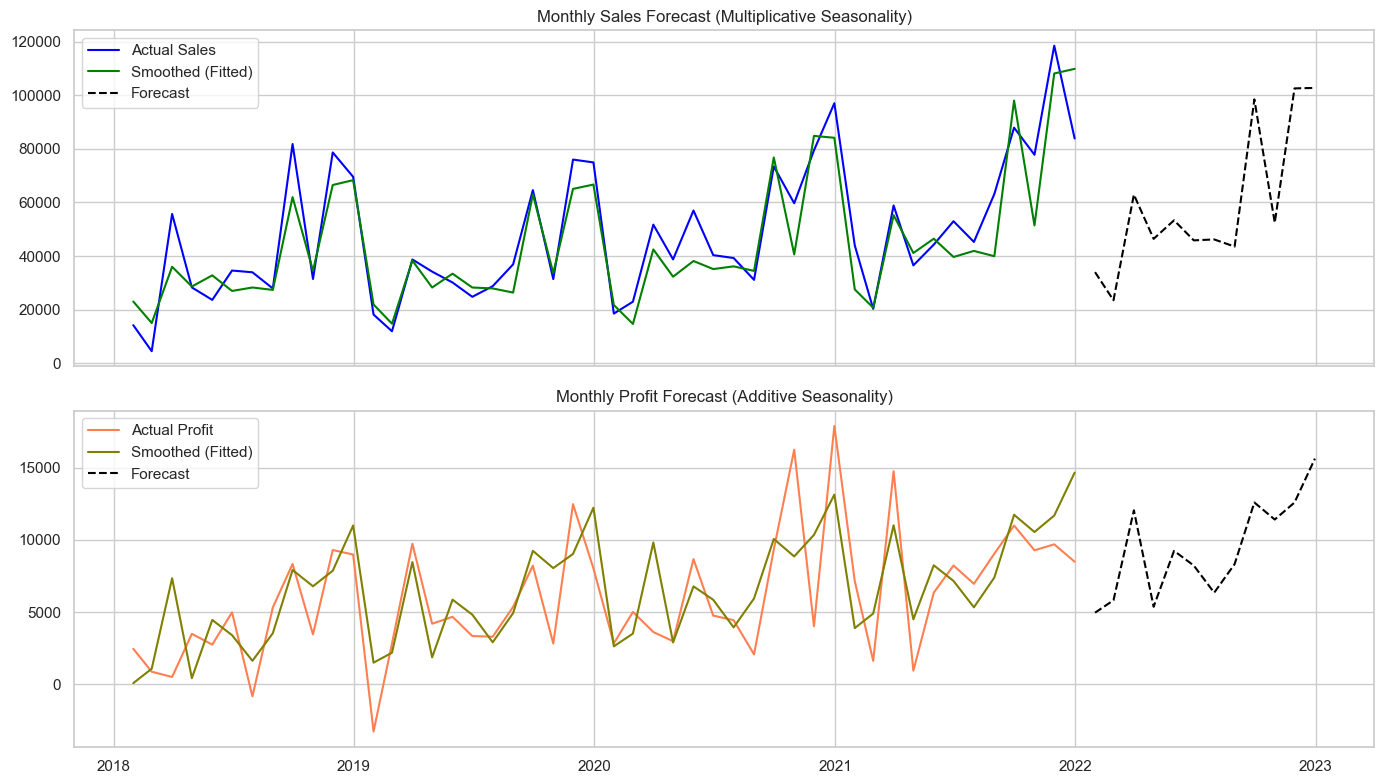

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd

# Reconstruct 'Order Date' from Year and Month (if not already present)
final_df['Order Date'] = pd.to_datetime(final_df['Order_Year'].astype(str) + '-' + final_df['Order_Month'].astype(str) + '-01')

# Sort by Order Date
final_df = final_df.sort_values('Order Date')

# Monthly aggregation
monthly = final_df.resample('M', on='Order Date').agg({'Sales': 'sum', 'Profit': 'sum'})

# Forecast horizon
forecast_periods = 12

# --- SALES MODEL (Multiplicative) ---
sales_model = ExponentialSmoothing(
    monthly['Sales'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit()

sales_fitted = sales_model.fittedvalues
sales_forecast = sales_model.forecast(forecast_periods)

# --- PROFIT MODEL (Additive) ---
profit_model = ExponentialSmoothing(
    monthly['Profit'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

profit_fitted = profit_model.fittedvalues
profit_forecast = profit_model.forecast(forecast_periods)

# --- PLOT ---
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Sales Plot
axs[0].plot(monthly.index, monthly['Sales'], label='Actual Sales', color='blue')
axs[0].plot(monthly.index, sales_fitted, label='Smoothed (Fitted)', color='green')
axs[0].plot(sales_forecast.index, sales_forecast, label='Forecast', linestyle='--', color='black')
axs[0].set_title('Monthly Sales Forecast (Multiplicative Seasonality)')
axs[0].legend()

# Profit Plot
axs[1].plot(monthly.index, monthly['Profit'], label='Actual Profit', color='coral')
axs[1].plot(monthly.index, profit_fitted, label='Smoothed (Fitted)', color='olive')
axs[1].plot(profit_forecast.index, profit_forecast, label='Forecast', linestyle='--', color='black')
axs[1].set_title('Monthly Profit Forecast (Additive Seasonality)')
axs[1].legend()

plt.tight_layout()
plt.show()


In [27]:
print(final_df.columns)


Index(['Row ID', 'Order ID', 'Ship Mode', 'Customer ID', 'Customer Name',
       'Segment', 'Country/Region', 'City', 'State', 'Postal Code', 'Region',
       'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Returned', 'Person', 'High_Profit',
       'Order_Month', 'Order_Year', 'Shipping_Duration', 'Sales_Per_Quantity',
       'Discount_Level', 'Shipping_Speed', 'Profitability', 'Order_DayOfWeek',
       'Ship_Year', 'Ship_Month', 'Ship_DayOfWeek', 'Order Date'],
      dtype='object')


In [28]:
# Create region_sales_returns DataFrame
region_sales_returns = orders_df.groupby('Region')[['Sales', 'Returned']].sum()

# Mean monthly returns
mean_returns = region_sales_returns.mean()

# Covariance matrix
cov_matrix = region_sales_returns.cov()

# Risk-free rate (monthly)
rf = 0.02 / 12  # 2% annual

# Equal weights (optional baseline)
weights_eq = np.array([1 / len(mean_returns)] * len(mean_returns))
portfolio_return_eq = np.dot(weights_eq, mean_returns)
portfolio_volatility_eq = np.sqrt(weights_eq.T @ cov_matrix @ weights_eq)
sharpe_eq = (portfolio_return_eq - rf) / portfolio_volatility_eq

print(f"Equal Weight Portfolio - Return: {portfolio_return_eq:.4f}, Volatility: {portfolio_volatility_eq:.4f}, Sharpe: {sharpe_eq:.4f}")

Equal Weight Portfolio - Return: 287250.1075, Volatility: 77770.1229, Sharpe: 3.6936


In [29]:
print("Mean Returns:\n", mean_returns)
print("\nCovariance Matrix:\n", cov_matrix)


Mean Returns:
 Sales       574300.215075
Returned       200.000000
dtype: float64

Covariance Matrix:
                  Sales      Returned
Sales     2.414585e+10  2.343848e+07
Returned  2.343848e+07  3.850867e+04



✅ Optimal Portfolio (Markowitz - Max Sharpe):
Central: 1.0000
East: 0.0000

🔹 Return: 574300.2151
🔹 Volatility: 155389.3580
🔹 Sharpe Ratio: 3.6959


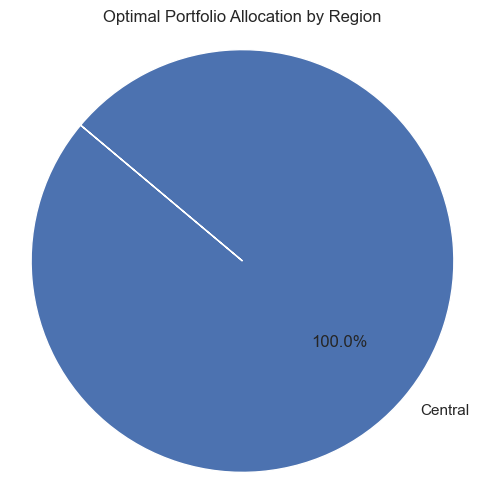

In [30]:
from scipy.optimize import minimize
# Objective function: Negative Sharpe Ratio
def neg_sharpe(weights, mean_returns, cov_matrix, rf):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -((ret - rf) / vol)

# Constraints: weights sum to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
# Bounds: no short selling (0 to 1)
bounds = tuple((0, 1) for _ in range(len(mean_returns)))
# Initial guess: equal weights
initial_guess = [1 / len(mean_returns)] * len(mean_returns)

# Optimization
opt_result = minimize(neg_sharpe, initial_guess,
                      args=(mean_returns, cov_matrix, rf),
                      method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = opt_result.x
# Only use regions with nonzero weights for the pie chart
nonzero_idx = np.where(optimal_weights > 1e-6)[0]
pie_labels = [region_sales_returns.index[i] for i in nonzero_idx]
pie_weights = optimal_weights[nonzero_idx]

# Optimal return, volatility, Sharpe
opt_return = np.dot(optimal_weights, mean_returns)
opt_volatility = np.sqrt(optimal_weights.T @ cov_matrix @ optimal_weights)
opt_sharpe = (opt_return - rf) / opt_volatility

print("\n✅ Optimal Portfolio (Markowitz - Max Sharpe):")
for region, weight in zip(region_sales_returns.index, optimal_weights):
    print(f"{region}: {weight:.4f}")

print(f"\n🔹 Return: {opt_return:.4f}")
print(f"🔹 Volatility: {opt_volatility:.4f}")
print(f"🔹 Sharpe Ratio: {opt_sharpe:.4f}")
# Pie chart of optimal weights
plt.figure(figsize=(6,6))
plt.pie(pie_weights, labels=pie_labels, autopct='%1.1f%%', startangle=140)
plt.title("Optimal Portfolio Allocation by Region")
plt.axis('equal')
plt.show()


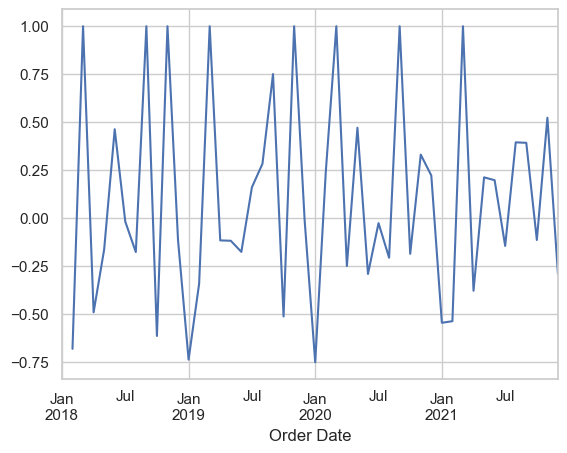

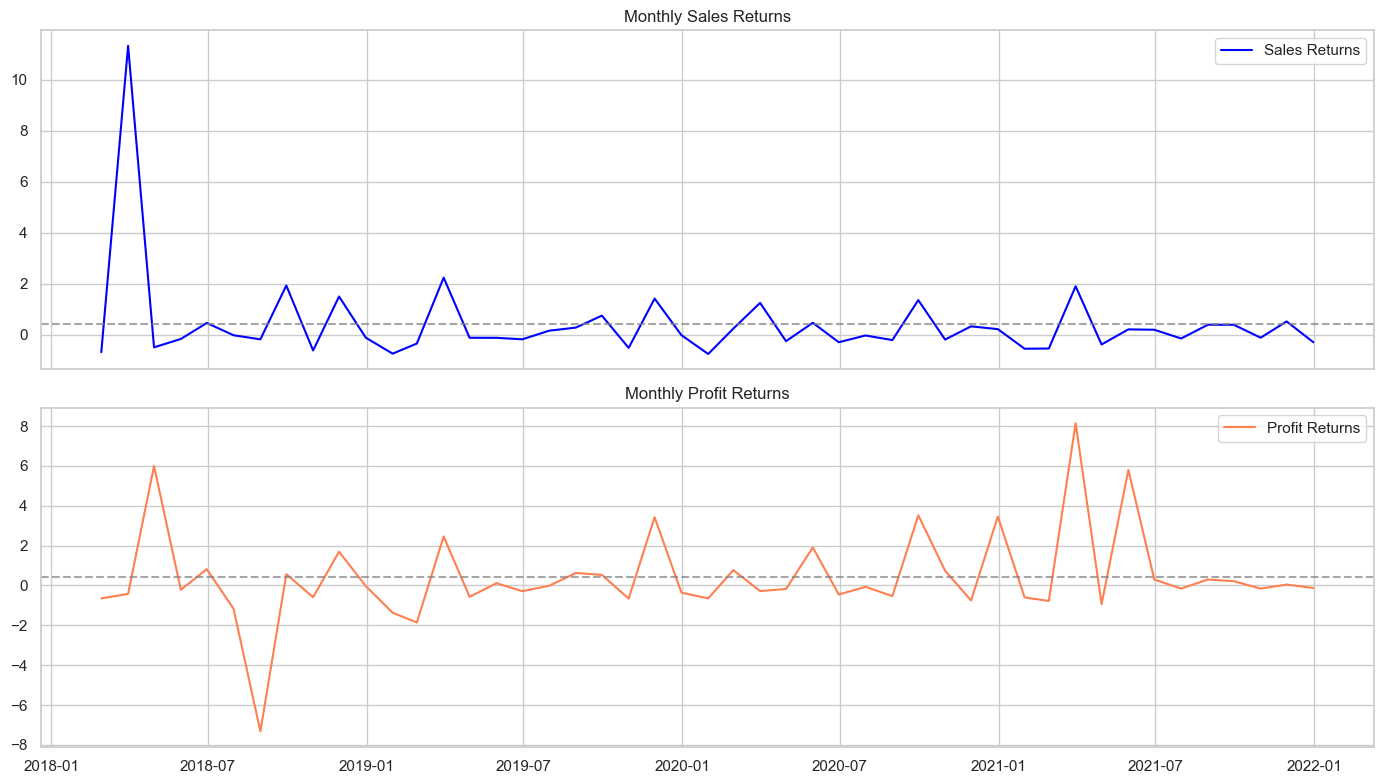

📈 Highest Profit Return Month: March 2021
📉 Lowest Profit Return Month: August 2018
Annualized Volatility for Sales: 6.1025
Annualized Volatility for Profit: 7.9011
Sharpe Ratio for Sales: 0.2359
Sharpe Ratio for Profit: 0.1892


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Ensure 'Order Date' is datetime
final_df['Order Date'] = pd.to_datetime(final_df['Order Date'])

# Step 2: Aggregate monthly Sales and Profit
monthly = final_df.groupby(pd.Grouper(key='Order Date', freq='M'))[['Sales', 'Profit']].sum()

# Step 3: Calculate monthly returns (percentage change)
monthly['Sales_Return'] = monthly['Sales'].pct_change()
monthly['Profit_Return'] = monthly['Profit'].pct_change()
monthly['Sales_Return'].clip(-1, 1).plot()  # clip between -100% and +100%


# Step 4: Plot returns
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axs[0].plot(monthly.index, monthly['Sales_Return'], label='Sales Returns', color='blue')
axs[0].axhline(monthly['Sales_Return'].mean(), color='gray', linestyle='--', alpha=0.7)
axs[0].set_title('Monthly Sales Returns')
axs[0].legend()

axs[1].plot(monthly.index, monthly['Profit_Return'], label='Profit Returns', color='coral')
axs[1].axhline(monthly['Profit_Return'].mean(), color='gray', linestyle='--', alpha=0.7)
axs[1].set_title('Monthly Profit Returns')
axs[1].legend()

plt.tight_layout()
plt.show()
# Drop NaNs just in case
monthly_clean = monthly.dropna()

# Find max and min profit return months
max_profit_month = monthly_clean['Profit_Return'].idxmax()
min_profit_month = monthly_clean['Profit_Return'].idxmin()

print("📈 Highest Profit Return Month:", max_profit_month.strftime('%B %Y'))
print("📉 Lowest Profit Return Month:", min_profit_month.strftime('%B %Y'))

# Step 5: Annualized volatility
annualized_vol_sales = np.std(monthly['Sales_Return'].dropna()) * np.sqrt(12)
annualized_vol_profit = np.std(monthly['Profit_Return'].dropna()) * np.sqrt(12)

# Step 6: Sharpe Ratio (assumes risk-free rate ≈ 0)
sharpe_sales = monthly['Sales_Return'].mean() / np.std(monthly['Sales_Return'].dropna())
sharpe_profit = monthly['Profit_Return'].mean() / np.std(monthly['Profit_Return'].dropna())

# Results
print(f"Annualized Volatility for Sales: {annualized_vol_sales:.4f}")
print(f"Annualized Volatility for Profit: {annualized_vol_profit:.4f}")
print(f"Sharpe Ratio for Sales: {sharpe_sales:.4f}")
print(f"Sharpe Ratio for Profit: {sharpe_profit:.4f}")


High Profit Month - Top Categories:
Category
Technology         11035.0759
Office Supplies     2715.9624
Furniture           1000.8532
Name: Profit, dtype: float64

Low Profit Month - Top Categories:
Category
Furniture           663.4717
Technology         1887.0326
Office Supplies    2767.6007
Name: Profit, dtype: float64
Avg discount (high profit): 0.13084033613445376
Avg discount (low profit): 0.1310457516339869


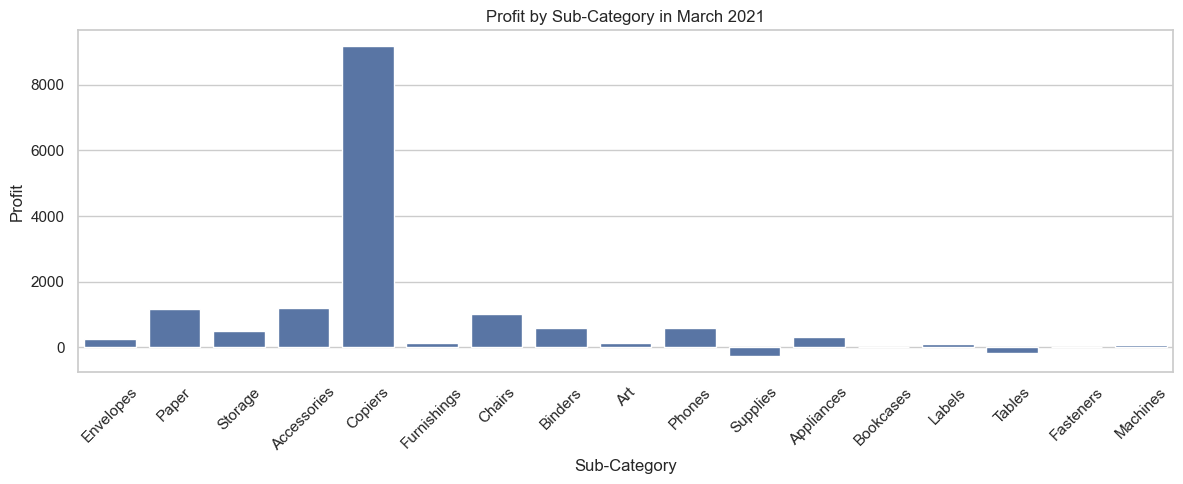

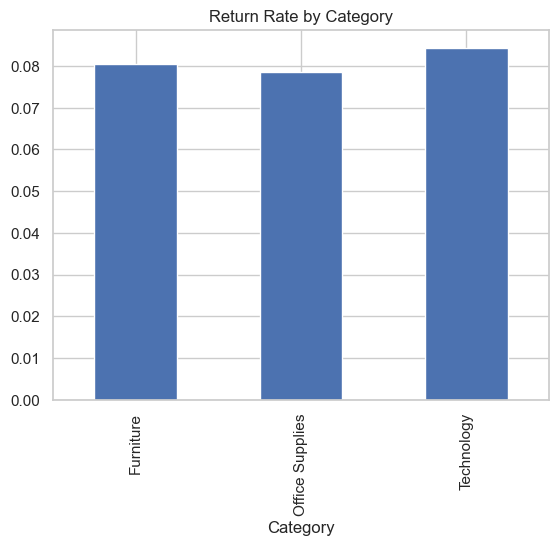

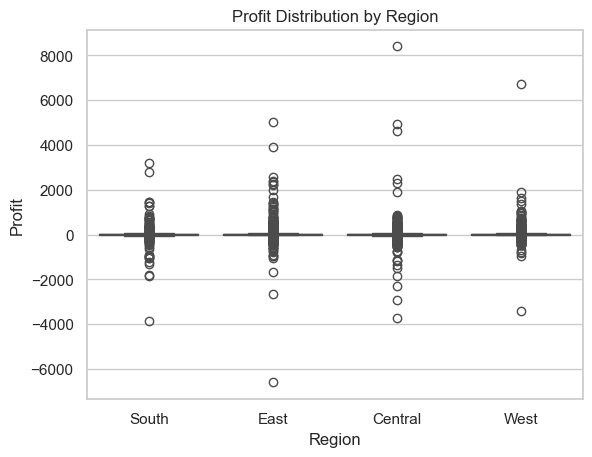

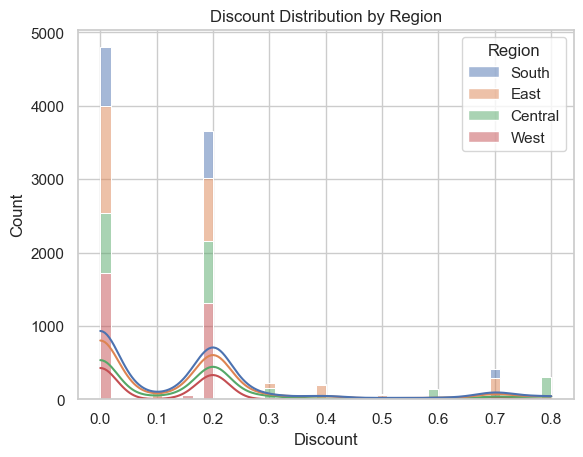

Portfolio Return: 35.92612630493361
Portfolio Volatility: 114.97925058114897
Sharpe Ratio: 0.31245747492133813


In [32]:
# Filter original data by those months
high_profit_data = final_df[(final_df['Order Date'].dt.to_period('M') == max_profit_month.to_period('M'))]
low_profit_data = final_df[(final_df['Order Date'].dt.to_period('M') == min_profit_month.to_period('M'))]
# Group by Category or Sub-Category
print("High Profit Month - Top Categories:")
print(high_profit_data.groupby('Category')['Profit'].sum().sort_values(ascending=False))

print("\nLow Profit Month - Top Categories:")
print(low_profit_data.groupby('Category')['Profit'].sum().sort_values())
import seaborn as sns
print("Avg discount (high profit):", high_profit_data['Discount'].mean())
print("Avg discount (low profit):", low_profit_data['Discount'].mean())


# Visual for high profit month
plt.figure(figsize=(12, 5))
sns.barplot(x='Sub-Category', y='Profit', data=high_profit_data, estimator=sum, ci=None)
plt.title(f'Profit by Sub-Category in {max_profit_month.strftime("%B %Y")}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Return rate by category
return_rate = final_df.groupby('Category')['Returned'].mean().plot(kind='bar', title='Return Rate by Category')
plt.show()

# Profit distribution by region
sns.boxplot(data=final_df, x='Region', y='Profit')
plt.title("Profit Distribution by Region")
plt.show()

# Discount distribution
sns.histplot(data=final_df, x='Discount', hue='Region', kde=True, multiple="stack")
plt.title("Discount Distribution by Region")
plt.show()

# Portfolio optimization (simplified version)
mean_returns = final_df.groupby('Category')['Profit'].mean()
cov_matrix = final_df.pivot_table(index='Order ID', columns='Category', values='Profit', aggfunc='sum').fillna(0).cov()
weights = np.array([1/3]*3)
portfolio_return = np.dot(weights, mean_returns)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
sharpe_ratio = portfolio_return / portfolio_volatility
print("Portfolio Return:", portfolio_return)
print("Portfolio Volatility:", portfolio_volatility)
print("Sharpe Ratio:", sharpe_ratio)



In [33]:
# Print all column names to inspect
print(orders_df.columns)


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country/Region', 'City',
       'State', 'Postal Code', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Returned'],
      dtype='object')


In [34]:
# Calculate a simple random sample (SRSWOR) from final_df
random_sample = final_df.sample(n=200, random_state=42)
variance_sales_srswor = random_sample['Sales'].var()

# Calculate a stratified sample by 'Category' (20% from each category)
stratified_sample = final_df.groupby('Category', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=42))

# Calculate standard error for SRSWOR
SE_srswor = np.sqrt(variance_sales_srswor / len(random_sample))

# Calculate mean for SRSWOR
mean_sales_sample = random_sample['Sales'].mean()

# Z-score for 95% confidence interval
Z = 1.96

# Construct 95% confidence interval for SRSWOR
CI_srswor = (mean_sales_sample - Z * SE_srswor, mean_sales_sample + Z * SE_srswor)

# Calculate variance for Stratified Sample
variance_sales_stratified = stratified_sample['Sales'].var()

# Calculate standard error for Stratified Sample
SE_stratified = np.sqrt(variance_sales_stratified / len(stratified_sample))

# Calculate mean for Stratified Sample
mean_sales_stratified = stratified_sample['Sales'].mean()

# Construct 95% confidence interval for Stratified Sample
CI_stratified = (mean_sales_stratified - Z * SE_stratified, mean_sales_stratified + Z * SE_stratified)

# Efficiency of Stratified Sampling
efficiency = variance_sales_srswor / variance_sales_stratified

# Print the results
print(f"Variance in Sales from SRSWOR: {variance_sales_srswor}")
print(f"Mean Sales from SRSWOR: {mean_sales_sample}")
print(f"Standard Error for SRSWOR: {SE_srswor}")
print(f"95% CI for SRSWOR Mean: {CI_srswor}")

print(f"Variance in Sales from Stratified Sample: {variance_sales_stratified}")
print(f"Mean Sales from Stratified Sample: {mean_sales_stratified}")
print(f"Standard Error for Stratified Sample: {SE_stratified}")
print(f"95% CI for Stratified Sample Mean: {CI_stratified}")

print(f"Efficiency of Stratified Sampling: {efficiency}")


Variance in Sales from SRSWOR: 104064.26128771769
Mean Sales from SRSWOR: 172.10303
Standard Error for SRSWOR: 22.810552523746292
95% CI for SRSWOR Mean: (np.float64(127.39434705345727), np.float64(216.8117129465427))
Variance in Sales from Stratified Sample: 273721.6321376097
Mean Sales from Stratified Sample: 226.38854504504505
Standard Error for Stratified Sample: 11.70460652404375
95% CI for Stratified Sample Mean: (np.float64(203.4475162579193), np.float64(249.3295738321708))
Efficiency of Stratified Sampling: 0.3801828173938435


In [35]:
import scipy.stats as stats
#Null Hypothesis (H0): The mean sales are the same across all regions.

#Alternative Hypothesis (H1): At least one region has a different mean sales

# Group data by Region and extract sales values
sales_by_region = orders_df.groupby('Region')['Sales']

# Perform One-Way ANOVA
anova_result = stats.f_oneway(sales_by_region.get_group('Central'),
                              sales_by_region.get_group('East'),
                              sales_by_region.get_group('South'),
                              sales_by_region.get_group('West'))

# Display ANOVA result
anova_result


F_onewayResult(statistic=np.float64(0.8006191034994181), pvalue=np.float64(0.49332032806553516))

In [36]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from patsy import dmatrix

# Fix column name with space using Q()
model = ols('Shipping_Duration ~ C(Q("Ship Mode"))', data=final_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                         sum_sq      df            F  PR(>F)
C(Q("Ship Mode"))  20736.485007     3.0  7058.333717     0.0
Residual            9783.115654  9990.0          NaN     NaN
